In [2]:
# !pip install keras
# !pip install pydot
# !pip install graphviz
# !pip install pydotplus

In [3]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras 
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow
import tarfile
import cv2
import h5py
import imageio
from PIL import Image
import matplotlib.pyplot as plt
from PIL import ImageOps
import pandas as pd
from skimage.util import img_as_ubyte
import csv
from numpy import savez_compressed
from numpy import load
import glob
import zipfile
%matplotlib inline
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation,Input
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers import Convolution2D
from keras.layers.core import Dropout
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical,plot_model,model_to_dot
import pydot
import graphviz
import pydotplus

Using TensorFlow backend.


Extract processed data set(array format in npz file)

In [6]:
extra_data1 = load(os.getcwd()+'/data/extra_cropped.npz', allow_pickle=True)
extra_data = extra_data1['arr_0']
extra_label = load(os.getcwd()+'/data/extra_label.npz', allow_pickle=True)
extra_label = extra_label['arr_0']

In [8]:
# read train image infomation from training array, which is stored in train_cropped.npz
# tra_images has shape (33402,64,64,3)
train_data1 = load(os.getcwd()+'/data/train_cropped.npz', allow_pickle=True)
train_images = np.asarray(train_data1['arr_0'])
print(train_images.shape)
# read array infomation from training array, which is stored in train_cropped.npz
# tra_images has shape (33402,6)
label_data1 = load(os.getcwd()+'/data/train_label.npz', allow_pickle=True)
train_labels = np.asarray(label_data1['arr_0'])
print(train_labels.shape)

(33402, 64, 64, 3)
(33402, 6)


In [9]:
# read train image infomation from training array, which is stored in train_cropped.npz
# tra_images has shape (13068, 64, 64, 3)
test_data1 = load(os.getcwd()+'/data/test_cropped.npz', allow_pickle=True)
test_images = np.asarray(test_data1['arr_0'])
print(test_images.shape)
# read array infomation from training array, which is stored in train_cropped.npz
# tra_images has shape (13068, 6)
label_data2 = load(os.getcwd()+'/data/test_label.npz', allow_pickle=True)
test_labels = np.asarray(label_data2['arr_0'])
print(test_labels.shape)

(13068, 64, 64, 3)
(13068, 6)


Get a large training data set by combining extra data and trainning data 

In [10]:
combined_train = np.concatenate((train_images, np.asarray(extra_data)))
combined_train_label = np.concatenate((train_labels, np.asarray( extra_label)))
print(combined_train.shape)
print(combined_train_label.shape)

(235755, 64, 64, 3)
(235755, 6)


In [11]:
# get test and train datasets
x_train = combined_train
x_test = test_images

In [12]:
# change the shape of array, which is similar to .T
def change_shape(array1):
    label_emp = np.empty((array1.shape[1],array1.shape[0]), dtype='uint8')
    for i in range(array1.shape[0]):
        for j in range(array1.shape[1]):
            label_emp[j,i] = array1[i,j]
    return label_emp

In [13]:
# get test accurracy
def test_acc(model_name):
    pre = model_name.predict(x_test, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
    n_pre = [np.argmax(i, axis = 1) for i in pre]
    n_pre = np.asarray(n_pre).T
    acc_result = np.sum(y_test.T == n_pre, axis = 1)
    return np.sum(acc_result==6)/len(y_test.T)

In [14]:
# reshape and test
y_train = change_shape(combined_train_label)
y_test = change_shape(test_labels)
if y_train.shape[0] == 6:
    print('y_train shape is right')
if y_test.shape[0] == 6:
    print('y_train shape is right')
# print(y_train[0].reshape([-1,1]))
# print(y_train.shape)

y_train shape is right
y_train shape is right


In [15]:
# read number of digits to one-hot code of shape(,6)
def digit_to_categorical_label(data):
    n = data.shape[0]   
    data_cat = np.empty([n, 6])
    for i in range(n):
        data_cat[i] = to_categorical(data[i], num_classes=6)        
    return data_cat

In [16]:
# read every digits to one-hot code of shape(,11)
def digit_to_categorical(data):
    n = data.shape[1]
    data_cat = np.empty([len(data), n, 11])    
    for i in range(n):
        data_cat[:, i] = to_categorical(data[:, i], num_classes=11)        
    return data_cat

In [17]:
# convert all train and test labels to one-hot code
y_train_num = digit_to_categorical_label(y_train[0])
y_train_digits = digit_to_categorical(y_train[1:])
y_test_num = digit_to_categorical_label(y_test[0])
y_test_digits = digit_to_categorical(y_test[1:])
# 
print(y_train_num.shape)
print(y_train_digits.shape)
print(y_test_num.shape)
print(y_test_digits.shape)

(235755, 6)
(5, 235755, 11)
(13068, 6)
(5, 13068, 11)


In [18]:
# function for get results of model for plotting
def get_array(his_name,i):
    val_loss = np.asarray(his_name.history['val_loss'])
    val_acc1 = np.asarray(his_name.history[f'val_dense_{i}_accuracy'])
    val_acc2 = np.asarray(his_name.history[f'val_dense_{i+1}_accuracy'])
    val_acc3 = np.asarray(his_name.history[f'val_dense_{i+2}_accuracy'])
    val_acc4 = np.asarray(his_name.history[f'val_dense_{i+3}_accuracy'])
    val_acc5 = np.asarray(his_name.history[f'val_dense_{i+4}_accuracy'])
    val_acc6 = np.asarray(his_name.history[f'val_dense_{i+5}_accuracy'])
    val_acc = val_acc1*val_acc2*val_acc3*val_acc4*val_acc5*val_acc6
    train_loss = np.asarray(his_name.history['loss'])
    train_acc1 = np.asarray(his_name.history[f'dense_{i}_accuracy'])
    train_acc2 = np.asarray(his_name.history[f'dense_{i+1}_accuracy'])
    train_acc3 = np.asarray(his_name.history[f'dense_{i+2}_accuracy'])
    train_acc4 = np.asarray(his_name.history[f'dense_{i+3}_accuracy'])
    train_acc5 = np.asarray(his_name.history[f'dense_{i+4}_accuracy'])
    train_acc6 = np.asarray(his_name.history[f'dense_{i+5}_accuracy'])
    train_acc =  train_acc1*train_acc2*train_acc3*train_acc4*train_acc5*train_acc6
    return val_loss,val_acc,train_loss,train_acc

In [19]:
def build_model2(rate):
    identifier = Sequential()
    Input_1 = Input(shape=(64,64,3))
    conv_model = BatchNormalization()(Input_1)
    conv_model = Convolution2D(48, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)
    conv_model = Dropout(rate)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(54, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)
    conv_model = Dropout(rate)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(128, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)
    conv_model = Dropout(0.1)(conv_model)
    conv_model = Dropout(rate)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(160, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)
    conv_model = Dropout(rate)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)
    conv_model = Dropout(rate)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)
    conv_model = Dropout(rate)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv_model)
    conv_model = Dropout(rate)(conv_model)

    conv_model = BatchNormalization()(conv_model)
    conv_model = Convolution2D(192, (5, 5), activation='relu',padding="same")(conv_model)
    conv_model = MaxPooling2D(pool_size=(2, 2), strides=(1,1))(conv_model)
    conv_model = Dropout(rate)(conv_model)

    conv_model = Flatten()(conv_model)
    conv_model = Dense(1024,activation = 'relu')(conv_model)
    conv_model = Dense(512,activation = 'relu')(conv_model)

    x1 = Dense(6, activation = 'softmax')(conv_model)
    x2 = Dense(11, activation = 'softmax')(conv_model)
    x3 = Dense(11, activation = 'softmax')(conv_model)
    x4 = Dense(11, activation = 'softmax')(conv_model)
    x5 = Dense(11, activation = 'softmax')(conv_model)
    x6 = Dense(11, activation = 'softmax')(conv_model)

    y = [x1,x2,x3,x4,x5,x6]

    identifier = Model(inputs = Input_1, outputs = y)
    return identifier

In [23]:
# model with different optimizers
# with optimizer stochastic Nadam
model1= build_model2(0.5)
# nadam = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model1.compile(optimizer = adam, loss = "categorical_crossentropy",metrics = ["accuracy"])
history1 = model1.fit(x=x_train,
               y=[y_train_num,y_train_digits[0],y_train_digits[1],y_train_digits[2],y_train_digits[3],y_train_digits[4]],
                batch_size=64, epochs=20,verbose=1,validation_split=0.2,shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 188604 samples, validate on 47151 samples
Epoch 1/20
188604/188604 [==============================] - 499s 3ms/step - loss: 3.7151 - dense_11_loss: 0.2989 - dense_12_loss: 1.0041 - dense_13_loss: 1.2630 - dense_14_loss: 0.9260 - dense_15_loss: 0.2165 - dense_16_loss: 0.0066 - dense_11_accuracy: 0.8883 - dense_12_accuracy: 0.6534 - dense_13_accuracy: 0.5589 - dense_14_accuracy: 0.6968 - dense_15_accuracy: 0.9428 - dense_16_accuracy: 0.9992 - val_loss: 0.9159 - val_dense_11_loss: 0.0857 - val_dense_12_loss: 0.1655 - val_dense_13_loss: 0.2700 - val_dense_14_loss: 0.2667 - val_dense_15_loss: 0.1219 - val_dense_16_loss: 0.0060 - val_dense_11_accuracy: 0.9762 - val_dense_12_accuracy: 0.9547 - val_dense_13_accuracy: 0.9263 - val_dense_14_accuracy: 0.9208 - val_dense_15_accuracy: 0.9615 - val_dense_16_accuracy: 0.9993
Epoch 2/20
188604/188604 [==============================] - 473s 3ms/step - loss: 1.2895 - dense_11_loss: 0.1148 - dense_

In [25]:
print(model1.metrics_names)

['loss', 'dense_11_loss', 'dense_12_loss', 'dense_13_loss', 'dense_14_loss', 'dense_15_loss', 'dense_16_loss', 'dense_11_accuracy', 'dense_12_accuracy', 'dense_13_accuracy', 'dense_14_accuracy', 'dense_15_accuracy', 'dense_16_accuracy']


Show the prediction accuracy of this model

In [31]:
test1_4 = test_acc(model1)
print(test1_4)
val_loss1_4,val_acc1_4,train_loss1_4,train_acc1_4 = get_array(history1,11)
val_acc1_4 = np.insert(val_acc1_4,0,0)
train_acc1_4 = np.insert(train_acc1_4,0,0)

0.9244444444444444


Accuracy history plot 

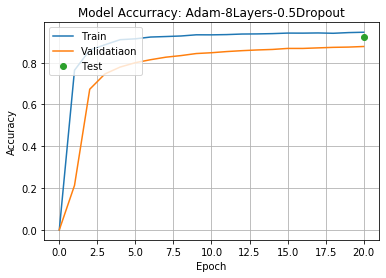

In [41]:
# plt.plot(val_loss1_2)
%matplotlib inline
# plt.plot(plt.plot(val_acc1_2))
plt.plot(val_acc1_4)
plt.plot(train_acc1_4)
plt.plot(20,test1_4,'o')
plt.title('Model Accurracy: Adam-8Layers-0.5Dropout')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validatiaon','Test'], loc='upper left')
plt.grid()
plt.savefig('nadam_with_extra.png')
plt.show()